# Setup

In [20]:
import numpy as np
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt

# Devide configuration 

In [21]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters

In [22]:
RANDOM_SEED = 42
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
N_EPOCHS = 10

IMG_SIZE = 32
N_CLASSES = 10

# Helper function

In [23]:
'''
  Function for computing the accuracy of the predictions over the entire data_loader
'''
def get_accuracy(model, data_loader, device):
  correct = 0
  total = 0
  
  with torch.no_grad():
    model.eval()
    for images, labels in data_loader:
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)

      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  return 100*(correct/total)

'''
  Function for plotting training and validation losses
'''
def plot_losses(train_losses, valid_losses):
  # change the style of the plots to seaborn
  plt.style.use('seaborn')

  train_losses = np.array(train_losses)
  valid_losses = np.array(valid_losses)

  fig, ax = plt.subplots(figsize=(8, 4.5))

  ax.plot(train_losses, color="blue", label="Training_loss")
  ax.plot(valid_losses, color="red", label="Validation_loss")
  ax.set(title="Loss over epochs",
          xlabel="Epoch",
          ylabel="Loss")
  ax.legend()
  fig.show()

  # change the plot style to default
  plt.style.use('default')

'''
  function for the training step of the training loop
'''
def train(train_loader, model, criterion, optimizer, device):
  model.train()
  running_loss = 0

  for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)

    # forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)
    running_loss += loss.item()

    # backward and optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  epoch_loss = running_loss / len(train_loader.dataset)

  return model, optimizer, epoch_loss 

'''
  function for the validation step of the training loop
'''
def validate(valid_loader, model, criterion, device):
  model.eval()
  running_loss = 0

  for images, labels in valid_loader:
    images = images.to(device)
    labels = labels.to(device)

    # forward pass and record loss
    outputs = model(images)
    loss = criterion(outputs, labels)
    running_loss = loss.item()
  
  epoch_loss = running_loss / len(valid_loader.dataset)

  return model, epoch_loss

'''
  function defining the entire training loop
'''
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
  # set object for storing metrics
  best_loss = 1e10
  train_losses = []
  valid_losses = []

  # train model
  for epoch in range(0, epochs):
    # training
    model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
    train_losses.append(train_loss)

    # validation
    with torch.no_grad():
      model, valid_loss = validate(valid_loader, model, criterion, device)
      valid_losses.append(valid_loss)

    if epoch % print_every == print_every - 1:
      train_acc = get_accuracy(model, train_loader, device=device)
      valid_acc = get_accuracy(model, valid_loader, device=device)

      print('Epochs: {}, Train_loss: {}, Valid_loss: {}, Train_accuracy: {}, Valid_accuracy: {}'.format(
            epoch, train_loss, valid_loss, train_acc, valid_acc
            ))

  plot_losses(train_losses, valid_losses)

  return model, optimizer, (train_losses, valid_losses)

# MNIST dataset

In [ ]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

In [25]:
transforms_compose = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(root='./', 
                                           train=True, 
                                           transform=transforms_compose,
                                           download=True)

valid_dataset = torchvision.datasets.MNIST(root='./', 
                                          train=False, 
                                          transform=transforms_compose)

# Data loader (input pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=False)

# Plot image

In [26]:
ROW_IMG = 10
N_ROWS = 5

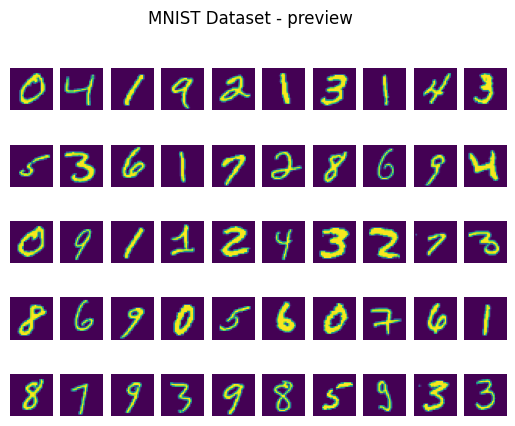

In [27]:
fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index])
fig.suptitle('MNIST Dataset - preview');

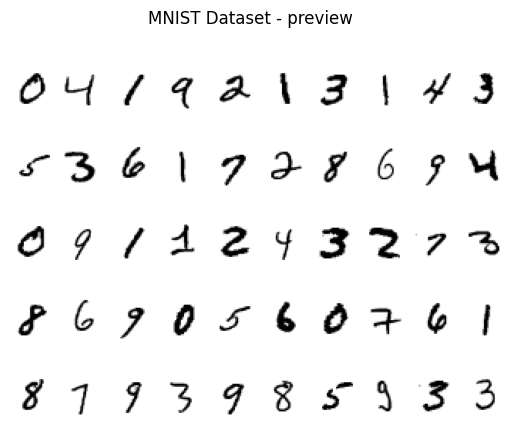

In [28]:
fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index], cmap='gray_r')
fig.suptitle('MNIST Dataset - preview');

# LeNet-5

In [29]:
class LeNet5(nn.Module):
  def __init__(self, n_classes):
    super(LeNet5, self).__init__()
    
    self.layer1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)
    self.layer2 = nn.AvgPool2d(kernel_size=2)
    self.layer3 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
    self.layer4 = nn.AvgPool2d(kernel_size=2)
    self.layer5 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)
    self.flatten = nn.Flatten()
    self.layer6 = nn.Linear(in_features=120, out_features=84)
    self.tanh = nn.Tanh()
    self.layer7 = nn.Linear(in_features=84, out_features=n_classes)
  
  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.layer5(out)
    out = self.flatten(out)
    out = self.layer6(out)
    out = self.tanh(out)
    out = self.layer7(out)

    return out

In [30]:
'''
  Another
'''
# class LeNet5(nn.Module):

#     def __init__(self, n_classes):
#         super(LeNet5, self).__init__()
        
#         self.feature_extractor = nn.Sequential(            
#             nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
#             nn.Tanh(),
#             nn.AvgPool2d(kernel_size=2),
#             nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
#             nn.Tanh(),
#             nn.AvgPool2d(kernel_size=2),
#             nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
#             nn.Tanh()
#         )

#         self.classifier = nn.Sequential(
#             nn.Linear(in_features=120, out_features=84),
#             nn.Tanh(),
#             nn.Linear(in_features=84, out_features=n_classes),
#         )


#     def forward(self, x):
#         x = self.feature_extractor(x)
#         x = torch.flatten(x, 1)
#         logits = self.classifier(x)
#         probs = F.softmax(logits, dim=1)
#         return logits, probs

'\n  Another\n'

# Create model

In [31]:
torch.manual_seed(RANDOM_SEED)
model = LeNet5(N_CLASSES).to(DEVICE)

# Loss and optimizer 

In [32]:
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# Train

Epochs: 0, Train_loss: 0.07186394615968068, Valid_loss: 0.0002306906461715698, Train_accuracy: 9.931666666666667, Valid_accuracy: 9.85
Epochs: 1, Train_loss: 0.07167247709035873, Valid_loss: 0.00022998626232147216, Train_accuracy: 10.066666666666666, Valid_accuracy: 9.950000000000001
Epochs: 2, Train_loss: 0.07147365531921386, Valid_loss: 0.00022924528121948243, Train_accuracy: 10.459999999999999, Valid_accuracy: 10.22
Epochs: 3, Train_loss: 0.07126011426051458, Valid_loss: 0.00022843971252441405, Train_accuracy: 11.706666666666667, Valid_accuracy: 11.59
Epochs: 4, Train_loss: 0.07102335324287415, Valid_loss: 0.00022753701210021974, Train_accuracy: 14.695, Valid_accuracy: 14.610000000000001
Epochs: 5, Train_loss: 0.07075289078553518, Valid_loss: 0.000226496958732605, Train_accuracy: 18.753333333333334, Valid_accuracy: 19.37
Epochs: 6, Train_loss: 0.0704352411389351, Valid_loss: 0.00022526516914367676, Train_accuracy: 24.705, Valid_accuracy: 25.69
Epochs: 7, Train_loss: 0.07005238856871

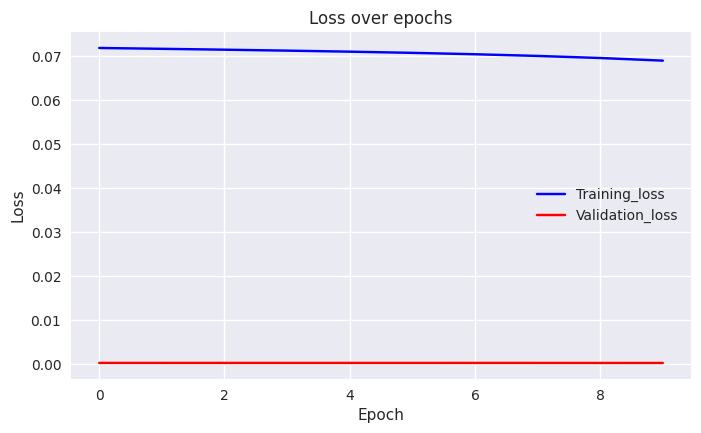

In [33]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)

# Save model



In [54]:
torch.save(model.state_dict(), 'LeNet_model.ckpt')